#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms


NUM_CLASSES = 10
INPUT_SHAPE = (3, 224, 224)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VGG16ObjectDetector(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(VGG16ObjectDetector, self).__init__()


        self.backbone = vgg16(pretrained=True)


        for param in self.backbone.parameters():
            param.requires_grad = False


        self.backbone.classifier = nn.Identity()


        self.features = self.backbone.features

        self.extra_layers = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.classifier = nn.Sequential(
            nn.Linear(256*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        self.bbox_regressor = nn.Sequential(
            nn.Linear(256*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4),  # [x, y, w, h]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.extra_layers(x)

        x = x.view(x.size(0), -1)


        cls_output = self.classifier(x)
        box_output = self.bbox_regressor(x)

        return cls_output, box_output

model = VGG16ObjectDetector(NUM_CLASSES).to(DEVICE)
print(model)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 57.7MB/s]


VGG16ObjectDetector(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [ ]:
import xml.etree.ElementTree as ET
from zipfile import ZipFile
import os

def parse_xml(zip_path, xml_filename):
    full_xml_path = f'Asirra: cat vs dogs/{xml_filename}'

    with ZipFile(zip_path, 'r') as zip_ref:
        if full_xml_path not in zip_ref.namelist():
            raise FileNotFoundError(f'Файл {full_xml_path} не найден в архиве')


        zip_ref.extract(full_xml_path, path='/tmp')
        temp_path = f'/tmp/{full_xml_path}'

        tree = ET.parse(temp_path)
        root = tree.getroot()

        size = root.find('size')
        width = float(size.find('width').text)
        height = float(size.find('height').text)


        obj = root.find('object')
        bndbox = obj.find('bndbox')


        raw_coords = {
            'xmin': float(bndbox.find('xmin').text),
            'ymin': float(bndbox.find('ymin').text),
            'xmax': float(bndbox.find('xmax').text),
            'ymax': float(bndbox.find('ymax').text)
        }


        scaled_coords = {
            'xmin': raw_coords['xmin'] / width,
            'ymin': raw_coords['ymin'] / height,
            'xmax': raw_coords['xmax'] / width,
            'ymax': raw_coords['ymax'] / height
        }


        os.remove(temp_path)
        os.removedirs(os.path.dirname(temp_path))

        return {
            "raw": raw_coords,
            "scaled": scaled_coords,
            "obj_name": obj.find('name').text
        }


if __name__ == "__main__":
    zip_path = '/content/animals.zip'
    xml_file = 'cat.0.xml'

    try:
        result = parse_xml(zip_path, xml_file)
        print(f"Результат обработки {xml_file}:")
        print(result)

    except Exception as e:
        print(f"Ошибка: {e}")

Результат обработки cat.0.xml:
{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0}, 'scaled': {'xmin': 0.252, 'ymin': 0.22192513368983957, 'xmax': 0.708, 'ymax': 0.6497326203208557}, 'obj_name': 'cat'}


<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
from zipfile import ZipFile
import io
import os

class AnimalDetectionDataset(Dataset):
    def __init__(self, zip_path, transforms=None, target_transform=None, return_scaled=True):

        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        self.samples = []
        with ZipFile(zip_path, 'r') as zip_ref:
            xml_files = [f for f in zip_ref.namelist()
                        if f.startswith('Asirra: cat vs dogs/') and f.endswith('.xml')]

            for xml_file in xml_files:

                img_file = xml_file.replace('.xml', '.jpg')
                if img_file in zip_ref.namelist():
                    self.samples.append((img_file, xml_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, xml_file = self.samples[idx]

        with ZipFile(self.zip_path, 'r') as zip_ref:
            img_data = zip_ref.read(img_file)
            image = Image.open(io.BytesIO(img_data)).convert('RGB')


            xml_data = zip_ref.read(xml_file)
            root = ET.fromstring(xml_data)


            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)


            objects = []
            for obj in root.iter('object'):

                class_name = obj.find('name').text
                if self.target_transform:
                    class_label = self.target_transform(class_name)
                else:
                    class_label = class_name


                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                if self.return_scaled:
                    xmin /= width
                    xmax /= width
                    ymin /= height
                    ymax /= height

                objects.append({
                    'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
                    'labels': torch.tensor([class_label], dtype=torch.int64)
                })


        target = {
            'boxes': torch.cat([obj['boxes'] for obj in objects]),
            'labels': torch.cat([obj['labels'] for obj in objects])
        }


        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

    @staticmethod
    def collate_fn(batch):

        images = [item[0] for item in batch]
        targets = [item[1] for item in batch]

        images = torch.stack(images, 0)

        return images, targets

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

Доступные классы: ['cat', 'dog']

Пример с кошкой:


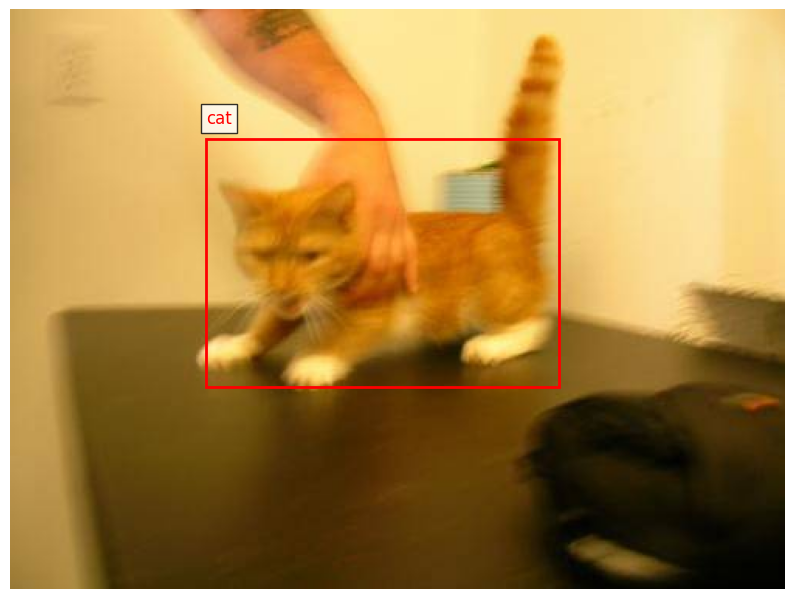


Пример с собакой:


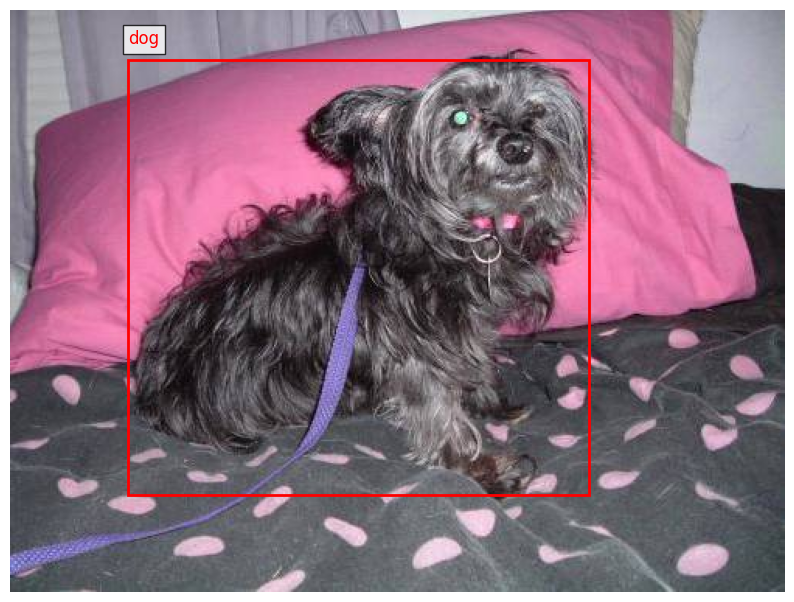

In [ ]:
import torch
import torch.utils.data as data
from PIL import Image
import io
import xml.etree.ElementTree as ET
import zipfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import List, Dict, Tuple

class AnimalDetectionDatasetFixed(data.Dataset):
    def __init__(self, zip_path: str, transforms=None, target_transform=None, return_scaled=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        self.class_to_idx = {'cat': 0, 'dog': 1}

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            self.samples = [
                (f, f.replace('.jpg', '.xml'))
                for f in zip_ref.namelist()
                if f.endswith('.jpg') and f.replace('.jpg', '.xml') in zip_ref.namelist()
            ]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict]:
        img_file, xml_file = self.samples[idx]


        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            img_data = zip_ref.read(img_file)
            image = Image.open(io.BytesIO(img_data)).convert('RGB')

            xml_data = zip_ref.read(xml_file)
            root = ET.fromstring(xml_data)

            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            objects = []
            for obj in root.iter('object'):
                class_name = obj.find('name').text.lower()
                class_label = self.class_to_idx[class_name]


                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)


                if self.return_scaled:
                    xmin /= width
                    xmax /= width
                    ymin /= height
                    ymax /= height

                objects.append({
                    'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
                    'labels': torch.tensor([class_label], dtype=torch.int64)
                })


            target = {
                'boxes': torch.cat([obj['boxes'] for obj in objects]),
                'labels': torch.cat([obj['labels'] for obj in objects]),
                'class_names': [obj.find('name').text for obj in root.iter('object')]
            }


            if self.transforms:
                image, target = self.transforms(image, target)

            return image, target

    def get_all_labels(self) -> List[str]:

        labels = []
        for idx in range(len(self)):
            _, target = self[idx]
            labels.extend(target['class_names'])
        return labels

def get_indices_by_class(dataset: AnimalDetectionDatasetFixed, class_name: str) -> List[int]:

    indices = []
    for idx in range(len(dataset)):
        _, target = dataset[idx]
        if class_name in target['class_names']:
            indices.append(idx)
    return indices

def show_image_with_bounding_box(dataset: AnimalDetectionDatasetFixed, index: int):

    image, target = dataset[index]

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    for box, label, class_name in zip(target['boxes'], target['labels'], target['class_names']):
        xmin, ymin, xmax, ymax = box.tolist()

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )

        ax.text(
            xmin,
            ymin - 10,
            class_name,
            color='red',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


if __name__ == "__main__":

    dataset = AnimalDetectionDatasetFixed(
        zip_path='animals.zip',
        transforms=None,
        target_transform=None,
        return_scaled=False
    )


    all_labels = dataset.get_all_labels()
    unique_labels = sorted(set(all_labels))
    print("Доступные классы:", unique_labels)


    cat_indices = get_indices_by_class(dataset, 'cat')
    dog_indices = get_indices_by_class(dataset, 'dog')


    if cat_indices:
        print("\nПример с кошкой:")
        show_image_with_bounding_box(dataset, cat_indices[0])

    if dog_indices:
        print("\nПример с собакой:")
        show_image_with_bounding_box(dataset, dog_indices[4])

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

Epoch 1/10
Train Loss: 10.6271, Val Loss: 5.2959
Epoch 2/10
Train Loss: 5.8976, Val Loss: 5.5975
Epoch 3/10
Train Loss: 5.8363, Val Loss: 5.7055
Epoch 4/10
Train Loss: 5.8135, Val Loss: 5.5637
Epoch 5/10
Train Loss: 5.8191, Val Loss: 5.6233
Epoch 6/10
Train Loss: 5.7935, Val Loss: 5.6990
Epoch 7/10
Train Loss: 5.7890, Val Loss: 5.6367
Epoch 8/10
Train Loss: 5.7879, Val Loss: 5.6316
Epoch 9/10
Train Loss: 5.7704, Val Loss: 5.6812
Epoch 10/10
Train Loss: 5.7563, Val Loss: 5.6125
Cat example:


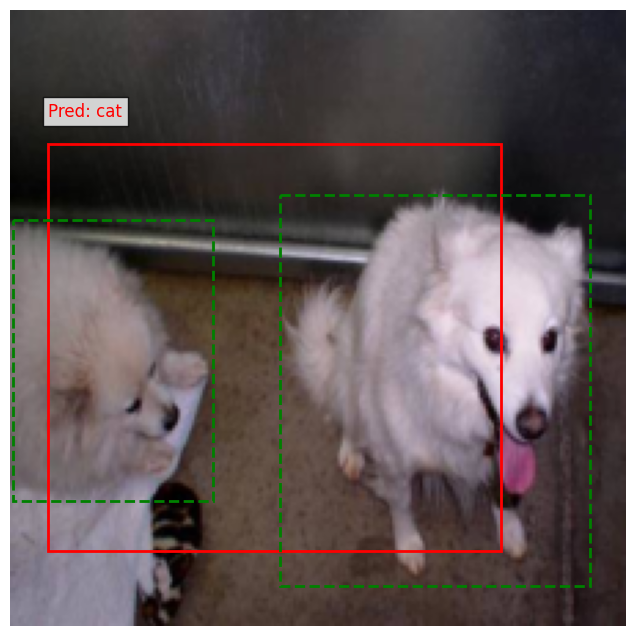

Dog example:


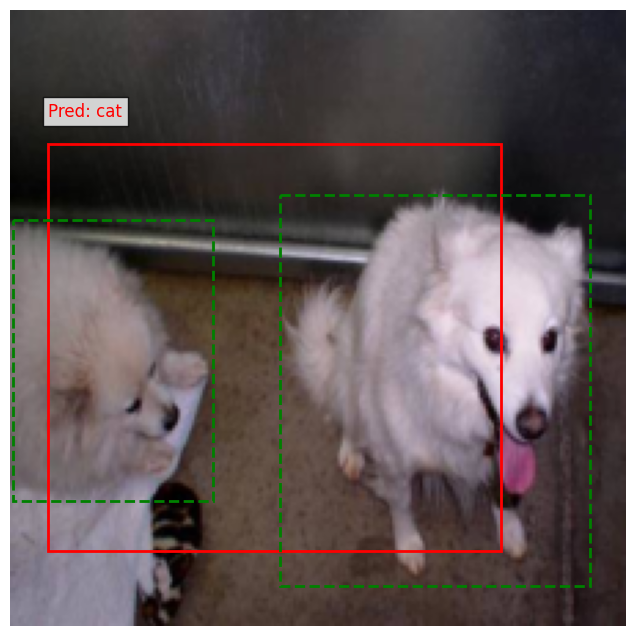

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import functional as F


class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.backbone = models.resnet50(pretrained=True)

        # Удаляем последний FC слой
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2]

        # Замораживаем веса backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Размер feature map после ResNet50 для изображения 224x224
        self.feature_size = 2048 * 7 * 7

        # Головы:
        # 1. Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes))

        # 2. Регрессор bounding box
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.feature_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 4),  # [xmin, ymin, xmax, ymax]
            nn.Sigmoid()  # Нормализация к [0, 1]
        )

        # Adaptive pooling для приведения к фиксированному размеру
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        # Извлекаем признаки
        features = self.backbone(x)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)  # Flatten

        # Предсказания
        class_logits = self.classifier(features)
        bbox_coords = self.bbox_regressor(features)

        return class_logits, bbox_coords

# 2. Трансформы (оставляем ваш CustomTransform без изменений)
class CustomTransform:
    def __init__(self, return_scaled=True):
        self.return_scaled = return_scaled
        self.image_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, image, target):
        image = self.image_transform(image)

        if 'size' in target:
            orig_width, orig_height = target['size']
        else:
            orig_width, orig_height = image.shape[2], image.shape[1]

        if 'boxes' in target and not self.return_scaled:
            boxes = target['boxes'].clone()
            boxes[:, [0, 2]] /= orig_width
            boxes[:, [1, 3]] /= orig_height
            target['boxes'] = boxes

        return image, target

transform = CustomTransform(return_scaled=True)
dataset = AnimalDetectionDataset(
    zip_path='animals.zip',
    transforms=transform,
    target_transform=None,
    return_scaled=True
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=AnimalDetectionDataset.collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=AnimalDetectionDataset.collate_fn
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ObjectDetectionModel(num_classes=2).to(device)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ObjectDetectionModel(num_classes=2).to(device)


for param in model.backbone.parameters():
    param.requires_grad = False


criterion_cls = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, targets in train_loader:
        images = images.to(device)

        optimizer.zero_grad()

        batch_loss = 0.0
        for i in range(len(images)):
            image = images[i].unsqueeze(0)
            target = {k: v.to(device) for k, v in targets[i].items()}

            class_pred, bbox_pred = model(image)


            if len(target['labels']) > 0:
                loss_cls = criterion_cls(
                    class_pred.repeat(len(target['labels']), 1),
                    target['labels']
                )

                loss_reg = criterion_reg(
                    bbox_pred.repeat(len(target['labels']), 1),
                    target['boxes']
                )
                batch_loss += loss_cls + loss_reg

        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item()


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)

            batch_loss = 0.0
            for i in range(len(images)):
                image = images[i].unsqueeze(0)
                target = {k: v.to(device) for k, v in targets[i].items()}

                class_pred, bbox_pred = model(image)

                if len(target['labels']) > 0:
                    loss_cls = criterion_cls(
                        class_pred.repeat(len(target['labels']), 1),
                        target['labels']
                    )
                    loss_reg = criterion_reg(
                        bbox_pred.repeat(len(target['labels']), 1),
                        target['boxes']
                    )
                    batch_loss += loss_cls + loss_reg

            val_loss += batch_loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')


def denormalize_image(tensor):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

def visualize_prediction(dataset, model, index):
    model.eval()
    image_tensor, target = dataset[index]

    with torch.no_grad():
        class_logits, bbox_coords = model(image_tensor.unsqueeze(0).to(device))


    class_pred = torch.argmax(class_logits, dim=1).item()
    bbox_pred = bbox_coords.squeeze().cpu().numpy()

    image = denormalize_image(image_tensor)
    image = image.permute(1, 2, 0).cpu().numpy()


    height, width = image.shape[:2]
    bbox_pred_scaled = bbox_pred * np.array([width, height, width, height])


    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)


    xmin, ymin, xmax, ymax = bbox_pred_scaled
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)


    if 'boxes' in target:
        for box in target['boxes']:
            box = box.cpu().numpy() * np.array([width, height, width, height])
            gt_rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor='g',
                facecolor='none',
                linestyle='--'
            )
            ax.add_patch(gt_rect)

    class_name = 'cat' if class_pred == 0 else 'dog'
    ax.text(
        xmin,
        ymin - 10,
        f'Pred: {class_name}',
        color='red',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    plt.axis('off')
    plt.show()


print("Cat example:")
visualize_prediction(val_dataset, model, 0)

print("Dog example:")

dog_idx = next(i for i, (_, target) in enumerate(val_dataset)
               if len(target['labels']) > 0 and target['labels'][0].item() == 1)
visualize_prediction(val_dataset, model, dog_idx)

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

Epoch 1/10
Train Loss: 1.5077, Val Loss: 0.7243
Epoch 2/10
Train Loss: 0.7266, Val Loss: 0.7071
Epoch 3/10
Train Loss: 0.7402, Val Loss: 0.7776
Epoch 4/10
Train Loss: 0.7248, Val Loss: 0.7686
Epoch 5/10
Train Loss: 0.7244, Val Loss: 0.7652
Epoch 6/10
Train Loss: 0.7216, Val Loss: 0.7588
Epoch 7/10
Train Loss: 0.7223, Val Loss: 0.7601
Epoch 8/10
Train Loss: 0.7227, Val Loss: 0.7593
Epoch 9/10
Train Loss: 0.7188, Val Loss: 0.7672
Epoch 10/10
Train Loss: 0.7226, Val Loss: 0.7780


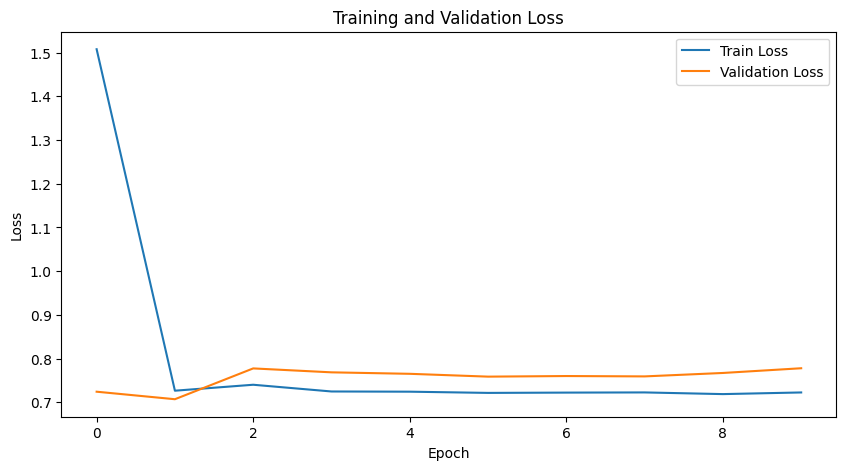

Пример предсказания для кошки:


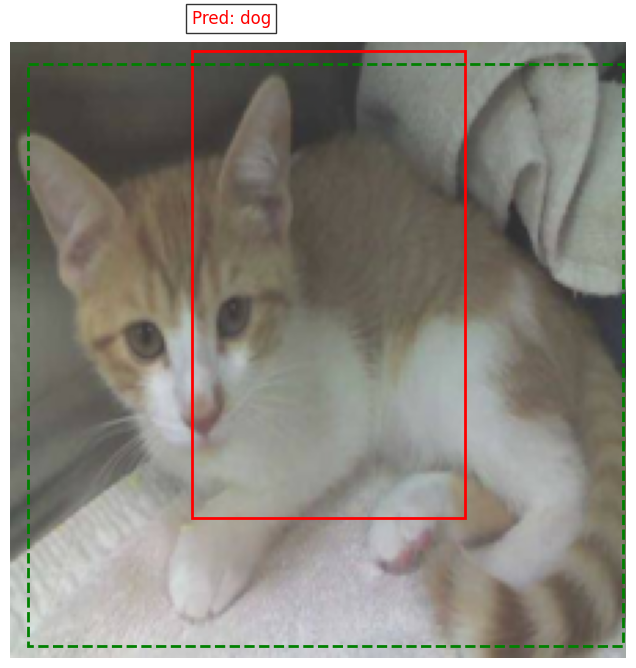

Пример предсказания для собаки:


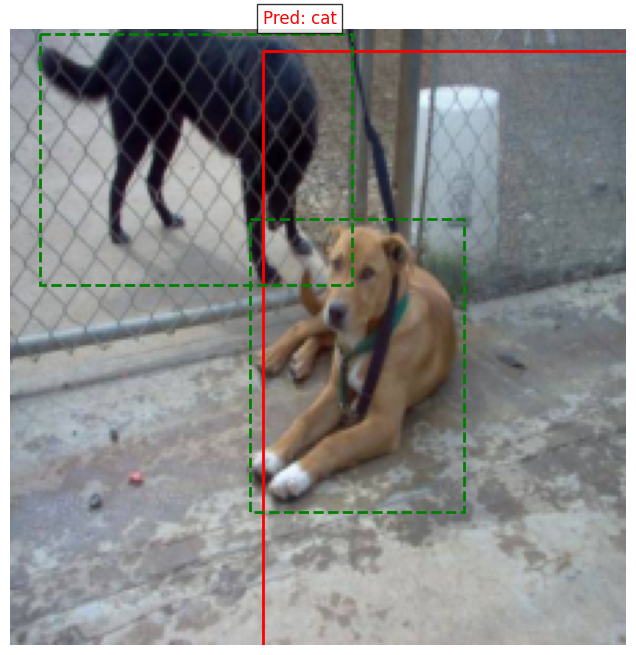

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F
import xml.etree.ElementTree as ET
from zipfile import ZipFile
import io
import os


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class AnimalDetectionDataset(Dataset):
    def __init__(self, zip_path, transforms=None, target_transform=None, return_scaled=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        self.class_to_idx = {'cat': 0, 'dog': 1}

        with ZipFile(zip_path, 'r') as zip_ref:
            self.samples = [
                (f, f.replace('.jpg', '.xml'))
                for f in zip_ref.namelist()
                if f.endswith('.jpg') and f.replace('.jpg', '.xml') in zip_ref.namelist()
            ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, xml_file = self.samples[idx]

        with ZipFile(self.zip_path, 'r') as zip_ref:

            img_data = zip_ref.read(img_file)
            image = Image.open(io.BytesIO(img_data)).convert('RGB')


            xml_data = zip_ref.read(xml_file)
            root = ET.fromstring(xml_data)

            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            objects = []
            for obj in root.iter('object'):
                class_name = obj.find('name').text.lower()
                class_label = self.class_to_idx[class_name]

                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)

                if self.return_scaled:
                    xmin /= width
                    xmax /= width
                    ymin /= height
                    ymax /= height

                objects.append({
                    'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
                    'labels': torch.tensor([class_label], dtype=torch.int64),
                    'class_name': class_name
                })

        target = {
            'boxes': torch.cat([obj['boxes'] for obj in objects]),
            'labels': torch.cat([obj['labels'] for obj in objects]),
            'class_names': [obj['class_name'] for obj in objects]
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target


class CustomTransform:
    def __call__(self, image, target):

        image = F.resize(image, (224, 224))
        image = F.to_tensor(image)
        image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        old_width, old_height = image.shape[2], image.shape[1]
        scale_x = 224 / old_width
        scale_y = 224 / old_height

        if 'boxes' in target:
            boxes = target['boxes']
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            target['boxes'] = boxes

        return image, target


def collate_fn(batch):
    images = []
    targets = []

    for image, target in batch:
        images.append(image)

        filtered_target = {
            'boxes': target['boxes'],
            'labels': target['labels']
        }
        targets.append(filtered_target)

    images = torch.stack(images, dim=0)
    return images, targets

def train_model(model, train_loader, val_loader, optimizer, num_epochs=4):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for images, targets in train_loader:
            batch_loss = 0.0
            optimizer.zero_grad()

            for i in range(len(images)):
                image = images[i].unsqueeze(0).to(device)
                target = {
                    'boxes': targets[i]['boxes'].to(device),
                    'labels': targets[i]['labels'].to(device)
                }

                class_pred, bbox_pred = model(image)

                num_objects = target['labels'].shape[0]
                class_pred_repeated = class_pred.repeat(num_objects, 1)
                bbox_pred_repeated = bbox_pred.repeat(num_objects, 1)

                loss_cls = nn.CrossEntropyLoss()(class_pred_repeated, target['labels'])
                loss_reg = nn.MSELoss()(bbox_pred_repeated, target['boxes'])
                loss = loss_cls + loss_reg

                loss.backward()
                batch_loss += loss.item()

            optimizer.step()
            running_train_loss += batch_loss / len(images)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                batch_loss = 0.0
                for i in range(len(images)):
                    image = images[i].unsqueeze(0).to(device)
                    target = {
                        'boxes': targets[i]['boxes'].to(device),
                        'labels': targets[i]['labels'].to(device)
                    }

                    class_pred, bbox_pred = model(image)

                    num_objects = target['labels'].shape[0]
                    class_pred_repeated = class_pred.repeat(num_objects, 1)
                    bbox_pred_repeated = bbox_pred.repeat(num_objects, 1)

                    loss_cls = nn.CrossEntropyLoss()(class_pred_repeated, target['labels'])
                    loss_reg = nn.MSELoss()(bbox_pred_repeated, target['boxes'])
                    batch_loss += (loss_cls + loss_reg).item()

                running_val_loss += batch_loss / len(images)

        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses

def denormalize_image(tensor):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def show_prediction(dataset, model, index):
    model.eval()
    image_tensor, target = dataset[index]

    with torch.no_grad():
        class_logits, bbox_coords = model(image_tensor.unsqueeze(0).to(device))

    class_pred = torch.argmax(class_logits, dim=1).item()
    bbox_pred = bbox_coords.squeeze().cpu().numpy()


    img = denormalize_image(image_tensor)
    img = img.permute(1, 2, 0).cpu().numpy()

    height, width = img.shape[:2]
    bbox_pred_scaled = bbox_pred * np.array([width, height, width, height])

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)


    xmin, ymin, xmax, ymax = bbox_pred_scaled
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)


    if 'boxes' in target:
        for box in target['boxes']:
            box = box.cpu().numpy() * np.array([width, height, width, height])
            gt_rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor='g',
                facecolor='none',
                linestyle='--'
            )
            ax.add_patch(gt_rect)

    class_name = 'cat' if class_pred == 0 else 'dog'
    ax.text(
        xmin,
        ymin - 10,
        f'Pred: {class_name}',
        color='red',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    plt.axis('off')
    plt.show()


def main():

    full_dataset = AnimalDetectionDataset(
        zip_path='animals.zip',
        transforms=CustomTransform(),
        target_transform=None,
        return_scaled=True
    )


    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        collate_fn=collate_fn
    )

    model = ObjectDetectionModel(num_classes=2).to(device)
    for param in model.backbone.parameters():
        param.requires_grad = False
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=10)


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    print("Пример предсказания для кошки:")
    show_prediction(val_dataset, model, 0)

    print("Пример предсказания для собаки:")
    show_prediction(val_dataset, model, len(val_dataset)-1)

if __name__ == "__main__":
    main()

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

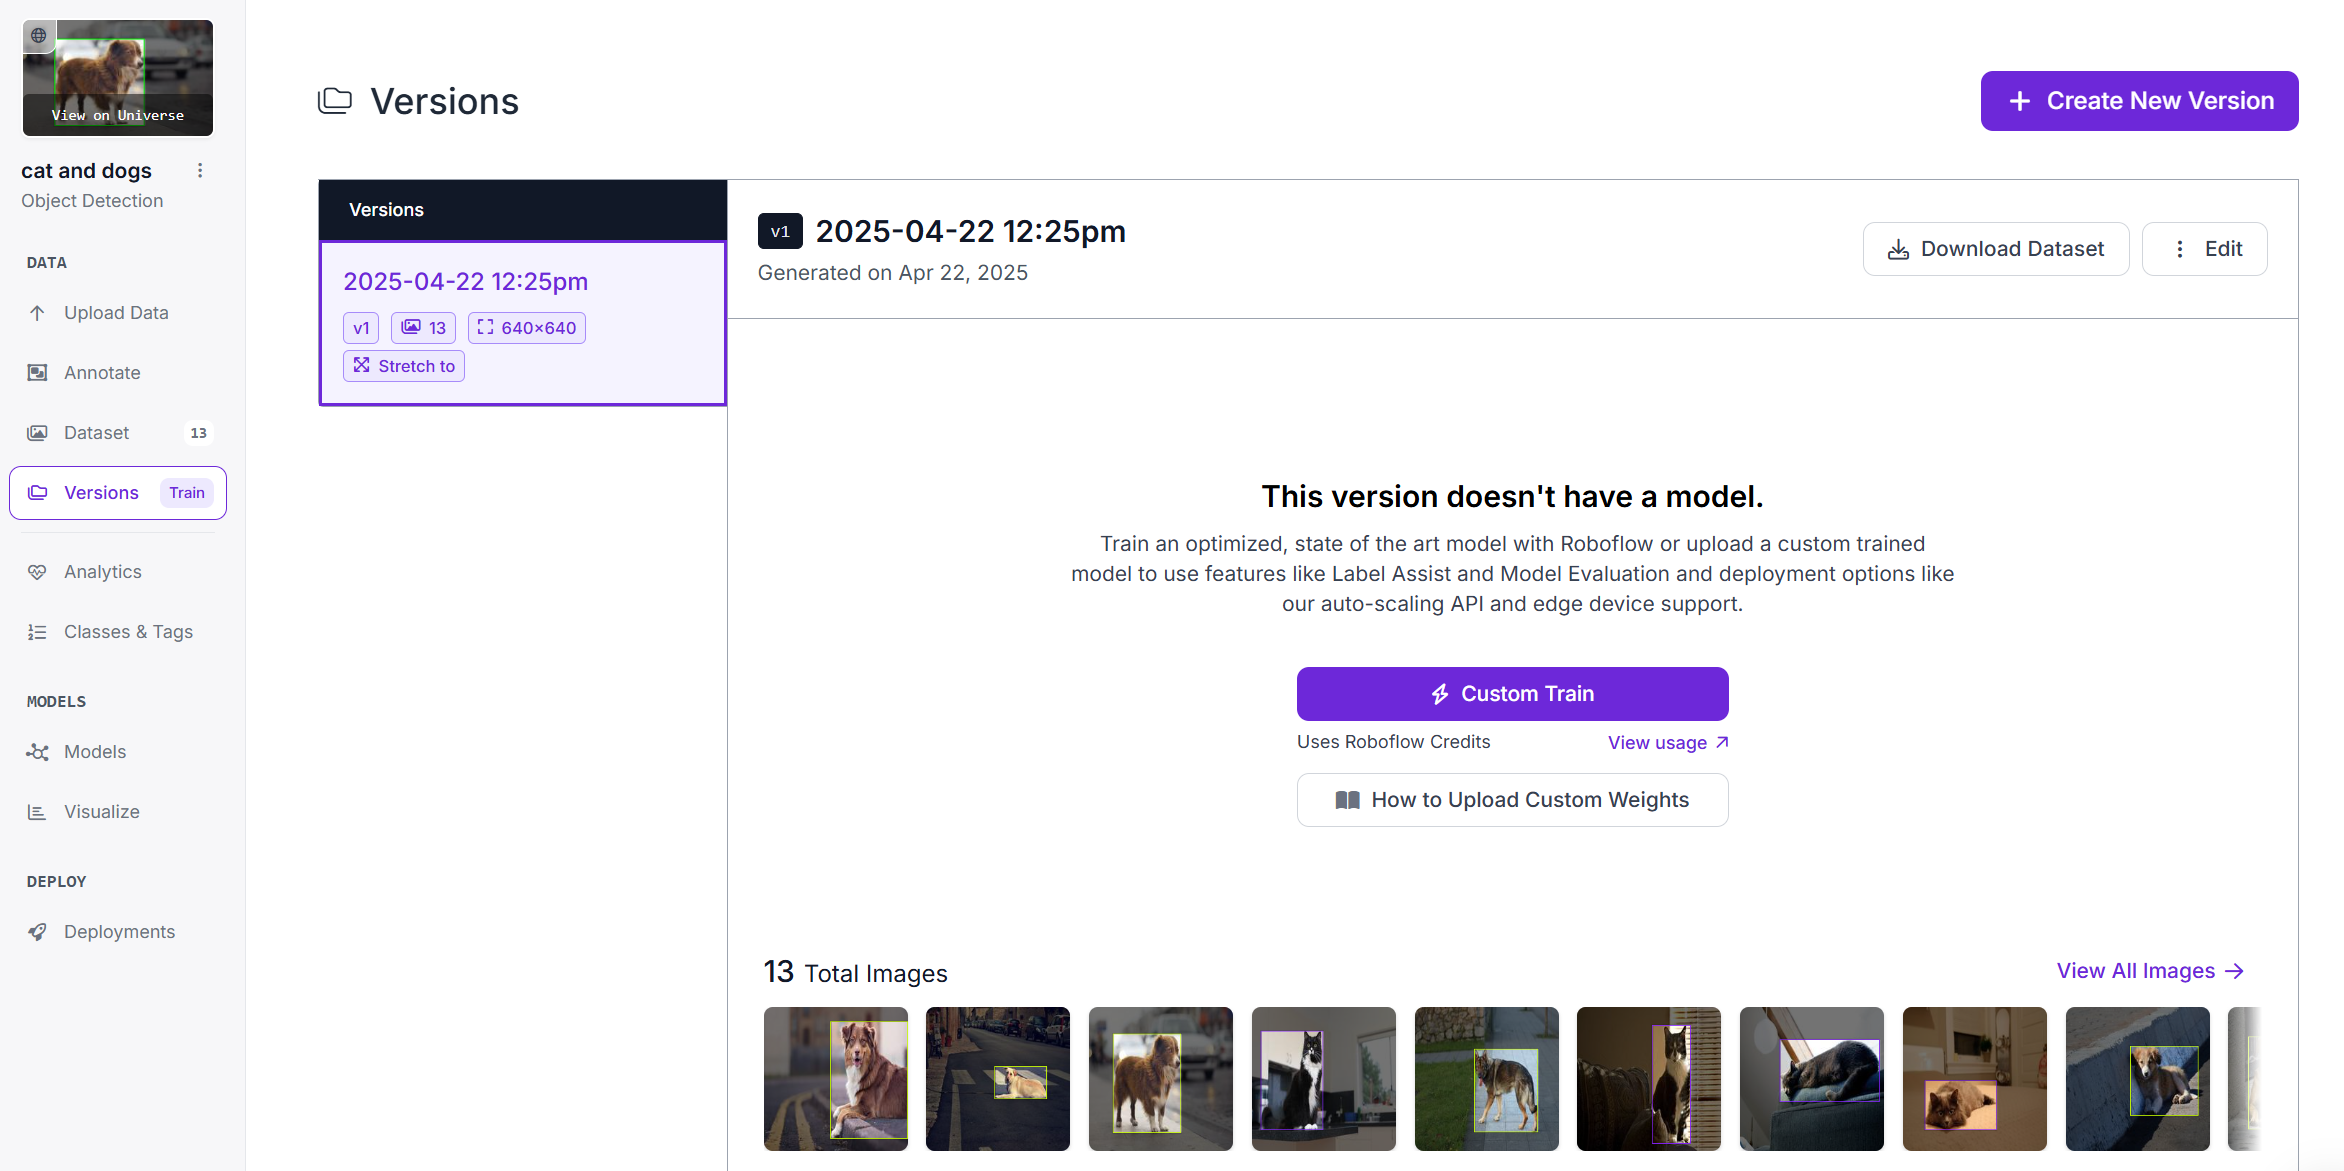

![image.png](![image.png](data:image/png;base64,)/6ugM7skKkEfg///WT+Os/Popn/PTluPCyk1MmAOiHAUdVPjbobmXkQXfHcRzHcRzHcRzHcRzn7sSD7o7jOM45wZ0F3eef7RZ0Z+rmlBKWiwU2Nz2Qek9idTRh+8int0b2voMNug0P5jl3nZwztra2sVqv9wwo22Ot7UopYWO5PG226rX/9kZc97t37Bp0P5VY+ewlIw+6O47jOI7jOI7jOI7jOHcnJ5Y/1XEcx3HOIeYB+N1Y9/38I+ccZ7k/4uCl7ae1ecDdORnsZm/mdmr+N+mHYc99J5vLHrCYf3TKyTmjH4b5x47jOI7jOI7jOI7jOI5zRuFBd8dxHOcei50xitlMyHEcdw2EOY7jnEzWfY9xHMvf8xnZNqA+3xdCwDAMWK9Pj6269AFLLDYjHvToffNdp4y+HzCO4651dxzHcRzHcRzHcRzHcZwzBQ+6O47jOI7BBri2t7cn+xzHcU4mOeeJnTnRGevz407XAKEv/Orz8LI/fyAe+y0H57tOGfO6zet+otzV8xzHcRzHcRzHcRzHcRznRPCgu+M4juPsQggBfT+gP03BLMdx7nn0fY++H+7SrG17Tt+vdwSnzwXWfY9+vS5/3xU5OY7jOI7jOI7jOI7jOM7pwIPujuM4zj2eeSDH/n1sa2uyz3Ec52Rh7cvx7NCdkVLG9vZq/vFZz2q1RvIZ6o7jOI7jOI7jOI7jOM5ZgAfdHcdxHMcwD3St1/05GcxyHOfuZXt7dVLWYg8hIISA9Xp9Ttkqkc+61M9xHMdxHMdxHMdxHMdxzmQ86O44juM4e8Bgz9Fjx3w9YMdxTho5Zxw9dmxHQPlEgsvHO2a1WmEcx/nHZx3jOGK12nsAwfFk4DiO4ziO4ziO4ziO4zh3Bx50dxzHcZxdsEGdlBKOHDk62e84jnNXOXLkKFJK5e+7GkSeB+z7YcDW1vbkmLORra1t9MN0rfu7KiPHcRzHcRzHcRzHcRzHOR140N1xHMdxTEBnPvOUn21tb2PL13d3HOczZGtrC1vb2ztsjf17/vmcGKev8PbvY1tbOHbs2GT/2cSxY8cma90fr66fDrvJ0XEcx3Ecx3Ecx3Ecx3FOFnfNa+U4juM4ZzG7BbZ2I4QwCfAcvv0OrNbryTGO4zgnymq9xuHb7yh/xxjv1A7dGfMAfQgBx7a2z8r13be3Vzi2tfuABMdxHMdxHMdxHMdxHMc5k/n/AaBcdbNjMXmKAAAAAElFTkSuQmCC)

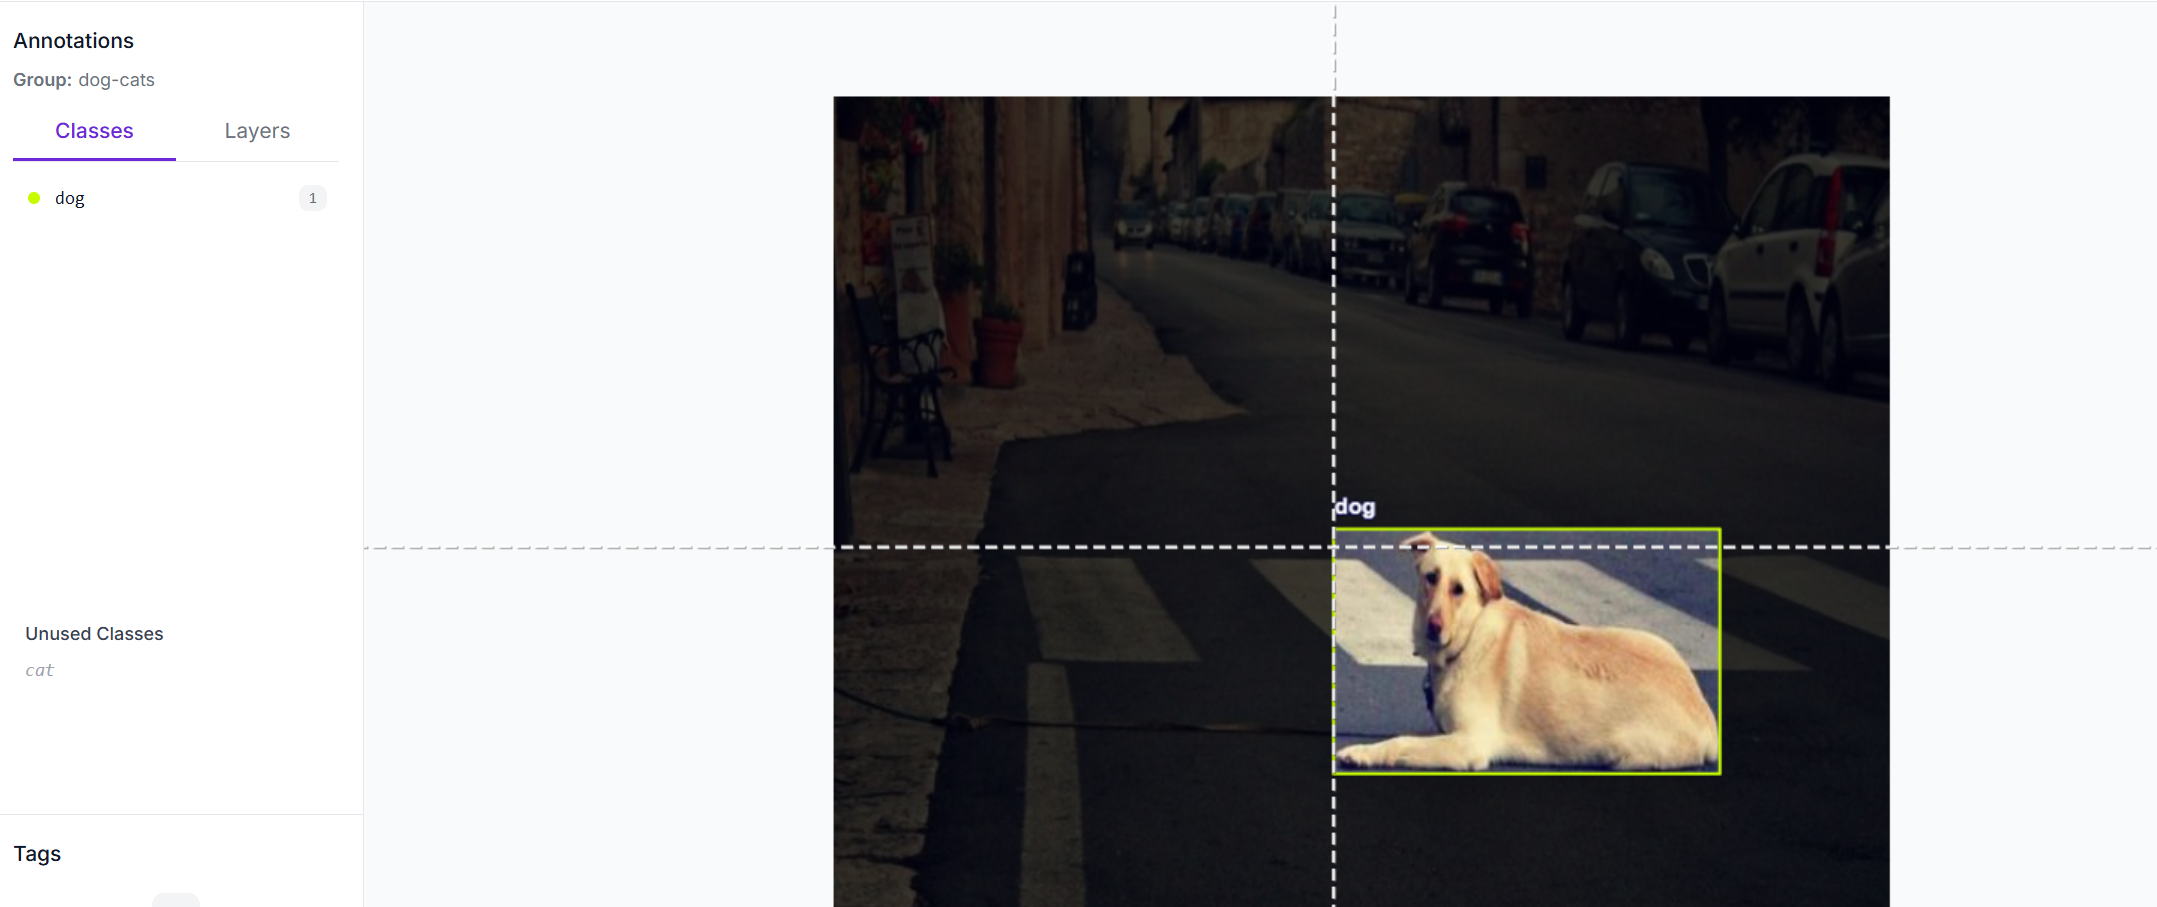

Доступные классы: ['cat', 'dog']

Пример с кошкой:


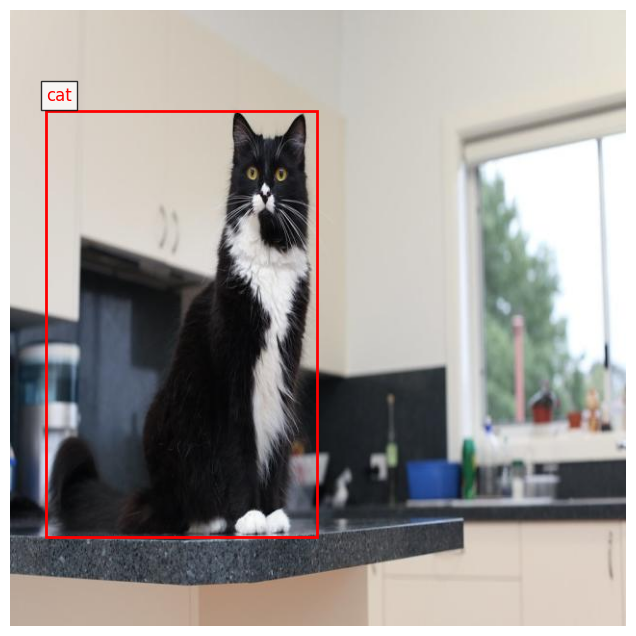


Пример с собакой:


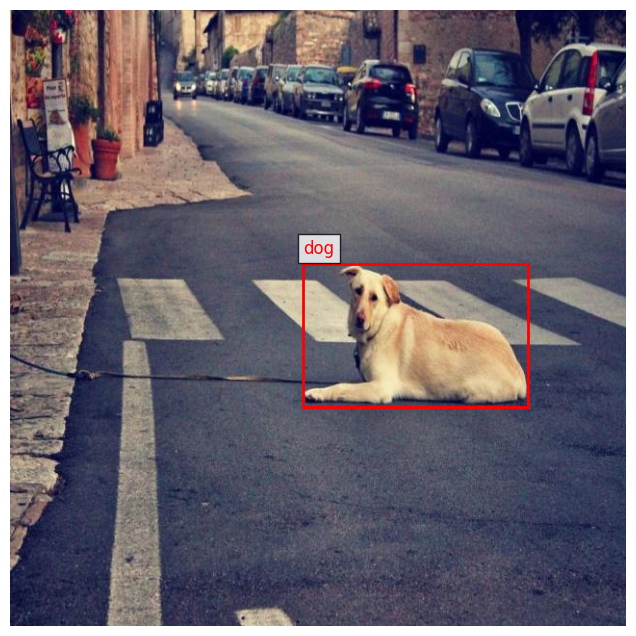

In [ ]:
class AnimalDetectionDatasetFixed(data.Dataset):
    def __init__(self, zip_path: str, transforms=None, target_transform=None, return_scaled=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        self.class_to_idx = {'cat': 0, 'dog': 1}


        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            self.samples = [
                (f, f.replace('.jpg', '.xml'))
                for f in zip_ref.namelist()
                if f.endswith('.jpg') and f.replace('.jpg', '.xml') in zip_ref.namelist()
            ]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict]:
        img_file, xml_file = self.samples[idx]


        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            img_data = zip_ref.read(img_file)
            image = Image.open(io.BytesIO(img_data)).convert('RGB')

            xml_data = zip_ref.read(xml_file)
            root = ET.fromstring(xml_data)

            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            objects = []
            for obj in root.iter('object'):
                class_name = obj.find('name').text.lower()
                class_label = self.class_to_idx[class_name]


                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)


                if self.return_scaled:
                    xmin /= width
                    xmax /= width
                    ymin /= height
                    ymax /= height

                objects.append({
                    'boxes': torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
                    'labels': torch.tensor([class_label], dtype=torch.int64)
                })


            target = {
                'boxes': torch.cat([obj['boxes'] for obj in objects]),
                'labels': torch.cat([obj['labels'] for obj in objects]),
                'class_names': [obj.find('name').text for obj in root.iter('object')]
            }


            if self.transforms:
                image, target = self.transforms(image, target)

            return image, target

    def get_all_labels(self) -> List[str]:

        labels = []
        for idx in range(len(self)):
            _, target = self[idx]
            labels.extend(target['class_names'])
        return labels

def get_indices_by_class(dataset: AnimalDetectionDatasetFixed, class_name: str) -> List[int]:

    indices = []
    for idx in range(len(dataset)):
        _, target = dataset[idx]
        if class_name in target['class_names']:
            indices.append(idx)
    return indices

def show_image_with_bounding_box(dataset: AnimalDetectionDatasetFixed, index: int):

    image, target = dataset[index]

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    for box, label, class_name in zip(target['boxes'], target['labels'], target['class_names']):
        xmin, ymin, xmax, ymax = box.tolist()

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )

        ax.text(
            xmin,
            ymin - 10,
            class_name,
            color='red',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


if __name__ == "__main__":

    dataset = AnimalDetectionDatasetFixed(
        zip_path='/content/cat and dogs.v1i.voc.zip',
        transforms=None,
        target_transform=None,
        return_scaled=False
    )


    all_labels = dataset.get_all_labels()
    unique_labels = sorted(set(all_labels))
    print("Доступные классы:", unique_labels)


    cat_indices = get_indices_by_class(dataset, 'cat')
    dog_indices = get_indices_by_class(dataset, 'dog')


    if cat_indices:
        print("\nПример с кошкой:")
        show_image_with_bounding_box(dataset, cat_indices[0])

    if dog_indices:
        print("\nПример с собакой:")
        show_image_with_bounding_box(dataset, dog_indices[4])

<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F
import xml.etree.ElementTree as ET
from zipfile import ZipFile
import io
import os


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


class AnimalDetectionDataset(Dataset):
    def __init__(self, zip_path, transforms=None, target_transform=None, return_scaled=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        with ZipFile(zip_path, 'r') as zip_ref:
            self.file_list = [f for f in zip_ref.namelist() if f.endswith('.jpg')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        with ZipFile(self.zip_path, 'r') as zip_ref:
            img_data = zip_ref.read(self.file_list[idx])
            image = Image.open(io.BytesIO(img_data)).convert("RGB")

            xml_file = self.file_list[idx].replace('.jpg', '.xml')
            xml_data = zip_ref.read(xml_file)
            root = ET.fromstring(xml_data)

            boxes = []
            labels = []
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                bndbox = obj.find('bndbox')
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(1 if class_name == 'cat' else 2)  # 1 - cat, 2 - dog

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels
            }

            if self.transforms is not None:
                image, target = self.transforms(image, target)

            return image, target

class CustomTransform:
    def __call__(self, image, target):

        image = F.to_tensor(image)

        if 'boxes' in target:
            boxes = target['boxes']
            if isinstance(boxes, np.ndarray):
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
            target['boxes'] = boxes

        return image, target

def collate_fn(batch):

    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets


def create_model(num_classes):

    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


    in_features = model.roi_heads.box_predictor.cls_score.in_features


    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for images, targets in train_loader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())


            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_train_loss += losses.item()


        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                running_val_loss += sum(loss for loss in loss_dict.values()).item()


        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses

def denormalize_image(tensor):
    return tensor.permute(1, 2, 0).cpu().numpy()

def show_prediction(dataset, model, index):
    model.eval()
    image, target = dataset[index]

    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    img = denormalize_image(image)

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)


    for box in target['boxes']:
        box = box.cpu().numpy()
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor='g',
            facecolor='none',
            linestyle='--'
        )
        ax.add_patch(rect)

    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > 0.5:
            box = box.cpu().numpy()
            label = label.cpu().item()

            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            class_name = 'cat' if label == 1 else 'dog'
            ax.text(
                box[0],
                box[1] - 10,
                f'{class_name}: {score:.2f}',
                color='red',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8)
            )

    plt.axis('off')
    plt.show()

def main():

    full_dataset = AnimalDetectionDataset(
        zip_path='animals.zip',
        transforms=CustomTransform(),
        target_transform=None,
        return_scaled=True
    )


    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn
    )


    model = create_model(num_classes=3)
    model.to(device)


    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=5)


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    print("Пример предсказания для кошки:")
    show_prediction(val_dataset, model, 0)

    print("Пример предсказания для собаки:")
    show_prediction(val_dataset, model, len(val_dataset)-1)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 105MB/s] 


## Обратная связь
- [ ] Хочу получить обратную связь по решению